In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
#https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_csv('original_dataset.csv', low_memory = False, dtype = {'locality': str, 'postcode': str, 'property_subtype': str})
raw_df = df

In [2]:
df = df[['locality', 'postcode', 'property_subtype', 'price', 'rooms_number', 'area']]
regex = "(10|11|12)\d{2}"
df = df[df.postcode.str.match(regex, na=False)|df.locality.str.match(regex, na=False)]

In [3]:
df = df.drop(df[df['price'].isnull()].index)
df = df.drop(df[df['area'].isnull()].index)

df = df.drop(df[df['price'] == 'None'].index)
df = df.drop(df[df['price'] == '@0'].index)
df = df.drop(df[df['price'] == '1À000'].index)
df = df.drop(df[df['price'] == '2À000'].index)
df = df.drop(df[df['price'] == '3À000'].index)
df = df.drop(df[df['price'] == '23456789'].index)

df = df.drop(df[df['area'] == 'None'].index)
df = df.drop(df[df['area'] == 'Not specified'].index)

df = df.drop(df[df['locality'] == '1044'].index)
df = df.drop(df[df['locality'] == '1212'].index)

In [4]:
df['locality'] = df['locality'].str.upper()
df['property_subtype'] = df['property_subtype'].str.upper()

In [5]:
character_map = {
    'É' : 'E',
    '\(' : '', 
    '\)' : '', 
    '_':'-'
}
df.replace(character_map, inplace=True, regex=True)

In [6]:
conversions = {
    'FLAT-STUDIO':'FLAT',
    'SERVICE-FLAT':'FLAT'
}
df['property_subtype'] = df['property_subtype'].map(conversions).fillna(df['property_subtype'])

In [7]:
def extract_postcode(d): 
    return re.sub("((\d{4}){0,1})(([A-Za-z- ]+[0-9]{0,2}){0,1})", r'\2',d)
df['extracted_pc_from_loc'] = df[~df['locality'].isnull()]['locality'].apply(extract_postcode)
df['extracted_pc_from_pc'] = df[~df['postcode'].isnull()]['postcode'].apply(extract_postcode)

In [8]:
df['merged_postcode'] = df['extracted_pc_from_loc'].replace(np.nan, '') + df['extracted_pc_from_pc'].replace(np.nan, '')
def unmerge_postcode(d): 
    return re.sub("(\d{4}){0,1}(\d{4})$", r'\2', d)
df['unmerged_postcode'] = df[~df['merged_postcode'].isnull()]['merged_postcode'].apply(unmerge_postcode)

In [9]:
df = df.drop(['locality', 'postcode', 'extracted_pc_from_loc', 'extracted_pc_from_pc', 'merged_postcode'], axis=1, errors='ignore')

In [10]:
def clean_area(d): 
    return re.sub('^([0-9]+)( {0,}m{0,}²{0,})', r'\1',d)
df['area'] = df['area'].apply(clean_area)

In [11]:
df['area'] = pd.to_numeric(df['area'])

In [12]:
df = df.drop(df[df['area']>600].index)

In [13]:
def clean_price(d): 
    return re.sub("^(€{0,})(([0-9\,\.])+)(€{0,})$", r'\2',d)
df['price'] = df['price'].apply(clean_price)

In [14]:
character_map = {
    '\.' : '', 
    '\,' : ''
}
df.replace(character_map, inplace=True, regex=True)

In [15]:
df['price'] = pd.to_numeric(df['price'])
df['area'] = pd.to_numeric(df['area'])

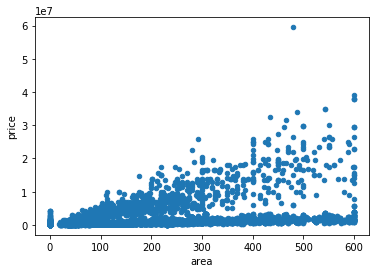

In [16]:
df.plot.scatter(x = 'area', y = 'price')

In [17]:
df = df.drop(df[df['price']==max(df['price'])].index)

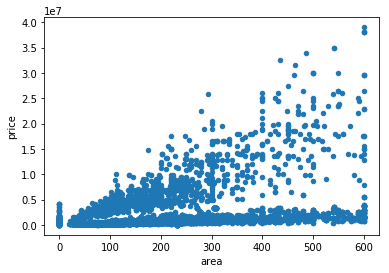

In [18]:
df.plot.scatter(x = 'area', y = 'price')

In [19]:
df['rooms_number'].unique()

array(['4', '2', '3', '7', '8', '5', '0', '6', '9', '10', '1', '11', '12',
       '20', '13', '28', '22', 'None', '60', '50', '40', '70', '30', '80',
       '00', '90', '100', '120', 'Not specified'], dtype=object)

In [20]:
df['rooms_number'] = pd.to_numeric(df['rooms_number'], errors='coerce')

In [21]:
df['rooms_number'].unique()

array([  4.,   2.,   3.,   7.,   8.,   5.,   0.,   6.,   9.,  10.,   1.,
        11.,  12.,  20.,  13.,  28.,  22.,  nan,  60.,  50.,  40.,  70.,
        30.,  80.,  90., 100., 120.])

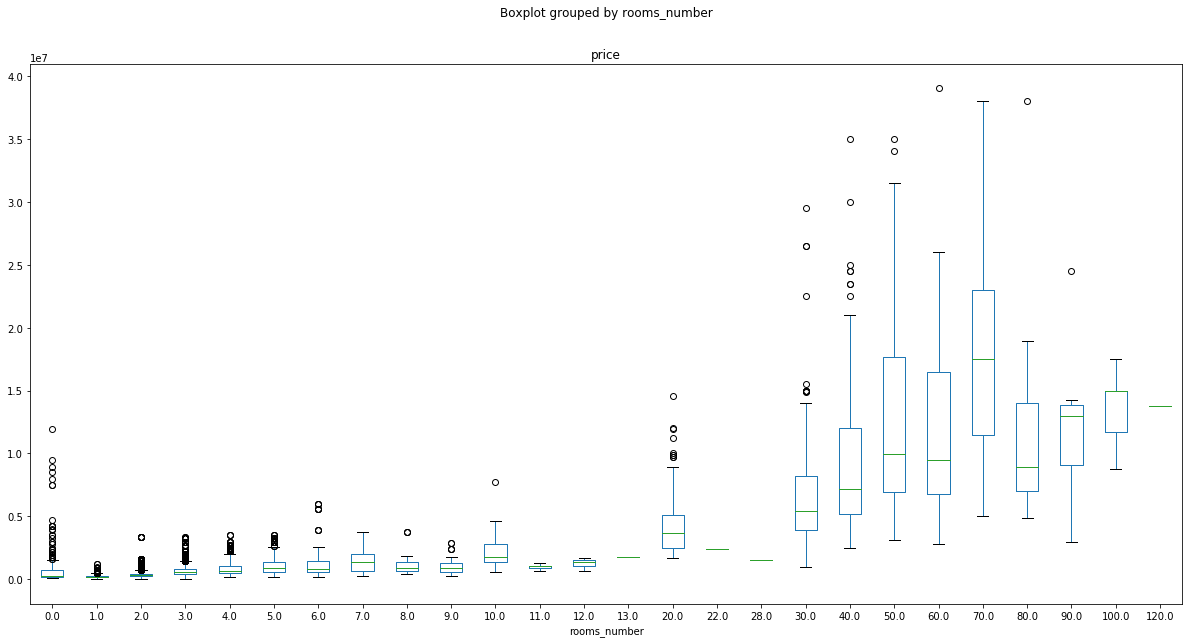

In [22]:
df.boxplot(by ='rooms_number', column =['price'], figsize=(20, 10), grid = False)

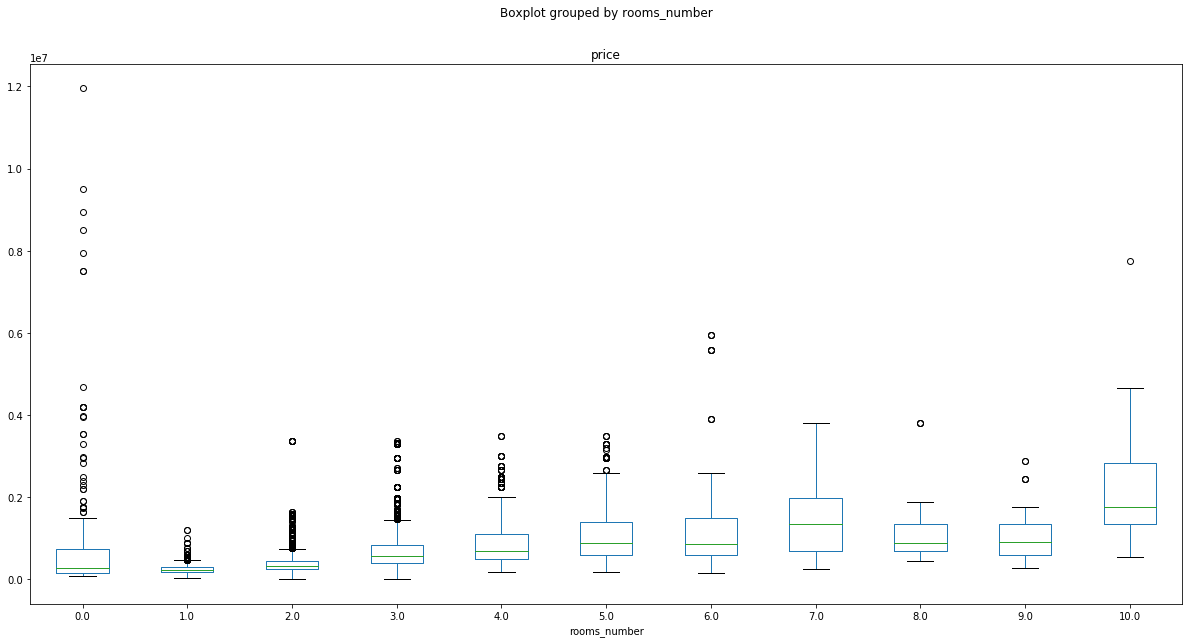

In [23]:
df_small_room = df[df['rooms_number']<11]
df_small_room.boxplot(by ='rooms_number', column =['price'], figsize=(20, 10), grid = False)

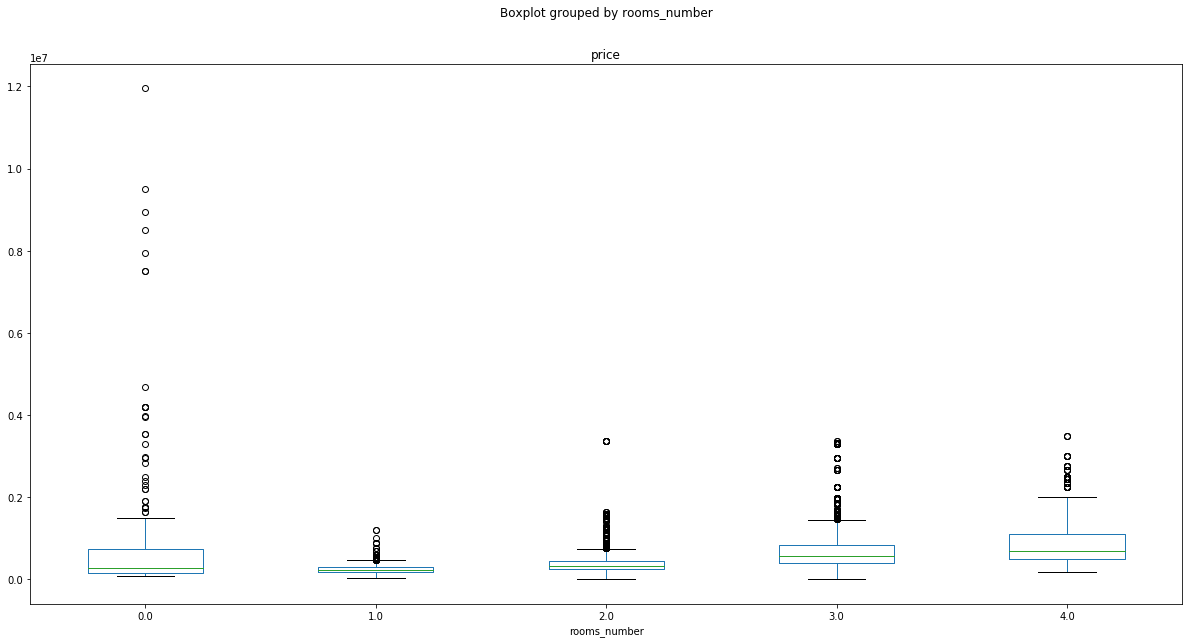

In [24]:
df_super_small_room = df[df['rooms_number']<5]
df_super_small_room.boxplot(by ='rooms_number', column =['price'], figsize=(20, 10), grid = False)

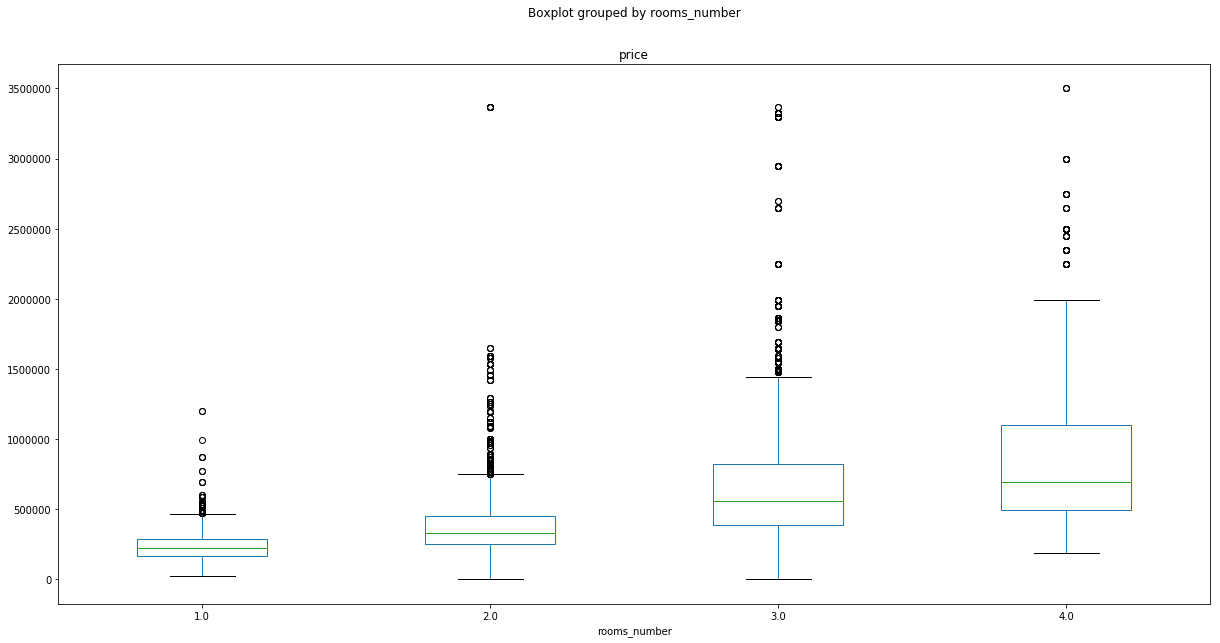

In [25]:
df_average_room = df_super_small_room[df_super_small_room['rooms_number']>0]
df_average_room.boxplot(by ='rooms_number', column =['price'], figsize=(20, 10), grid = False)

C:\Users\Mathi\Anaconda2\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


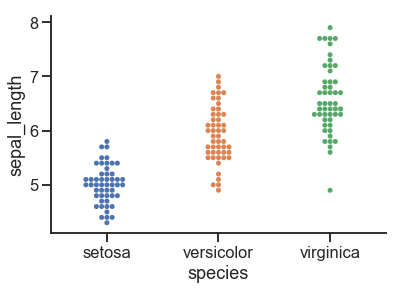

In [26]:
import seaborn as sns

sns.set(style='ticks', context='talk')
iris = sns.load_dataset('iris')

sns.swarmplot('species', 'sepal_length', data=iris)
sns.despine()

In [27]:
#sns.swarmplot('unmerged_postcode', 'price', data = df)

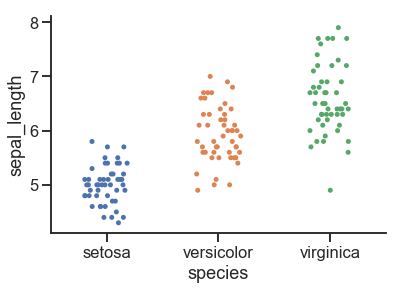

In [28]:
sns.stripplot('species', 'sepal_length', data=iris, jitter=0.2)
sns.despine()

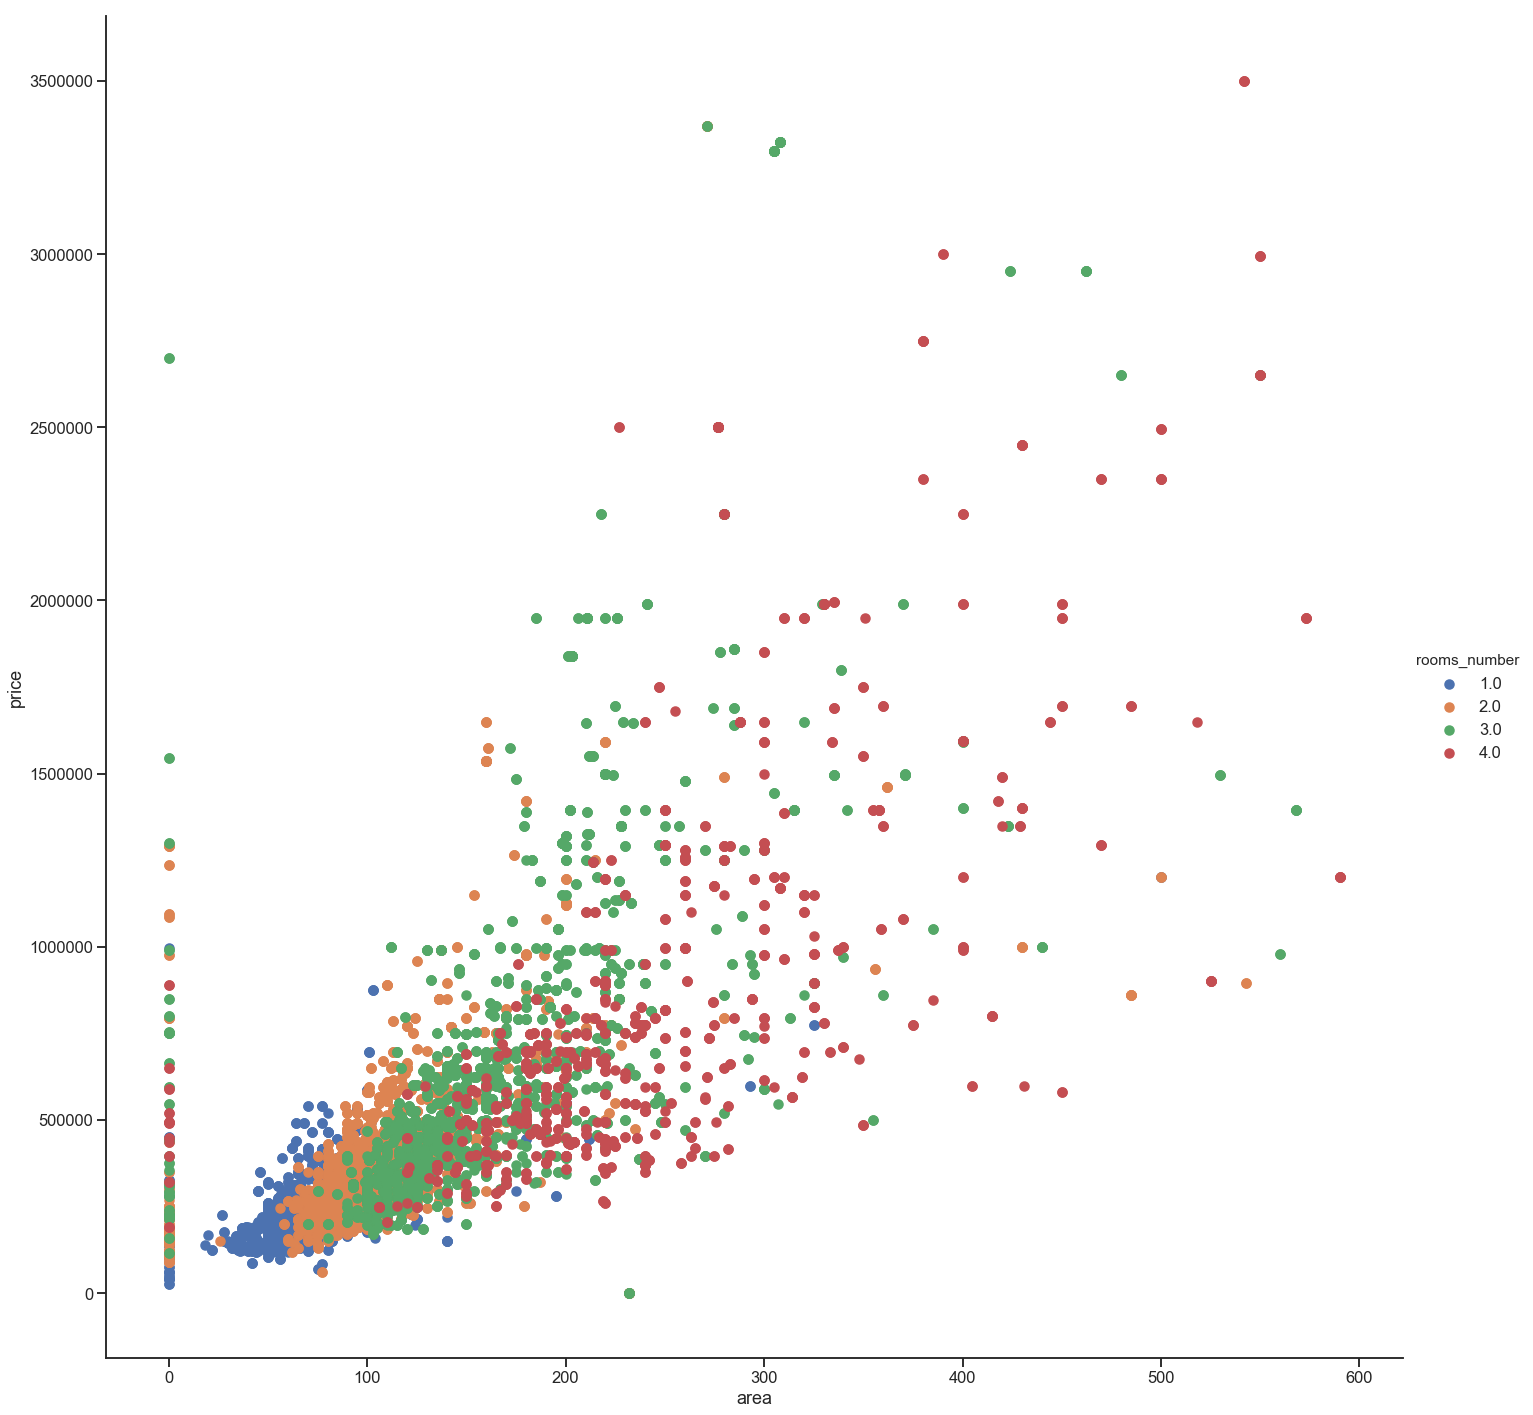

In [29]:
import seaborn as sns
fg = sns.FacetGrid(data=df_average_room, hue='rooms_number', height = 20, aspect=1)
fg.map(plt.scatter, 'area', 'price').add_legend()

In [30]:
df_pc = pd.read_csv('postcodes.csv', dtype = {'postcode': str})
df_original = df
df = df.rename(columns={'unmerged_postcode': 'postcode'})

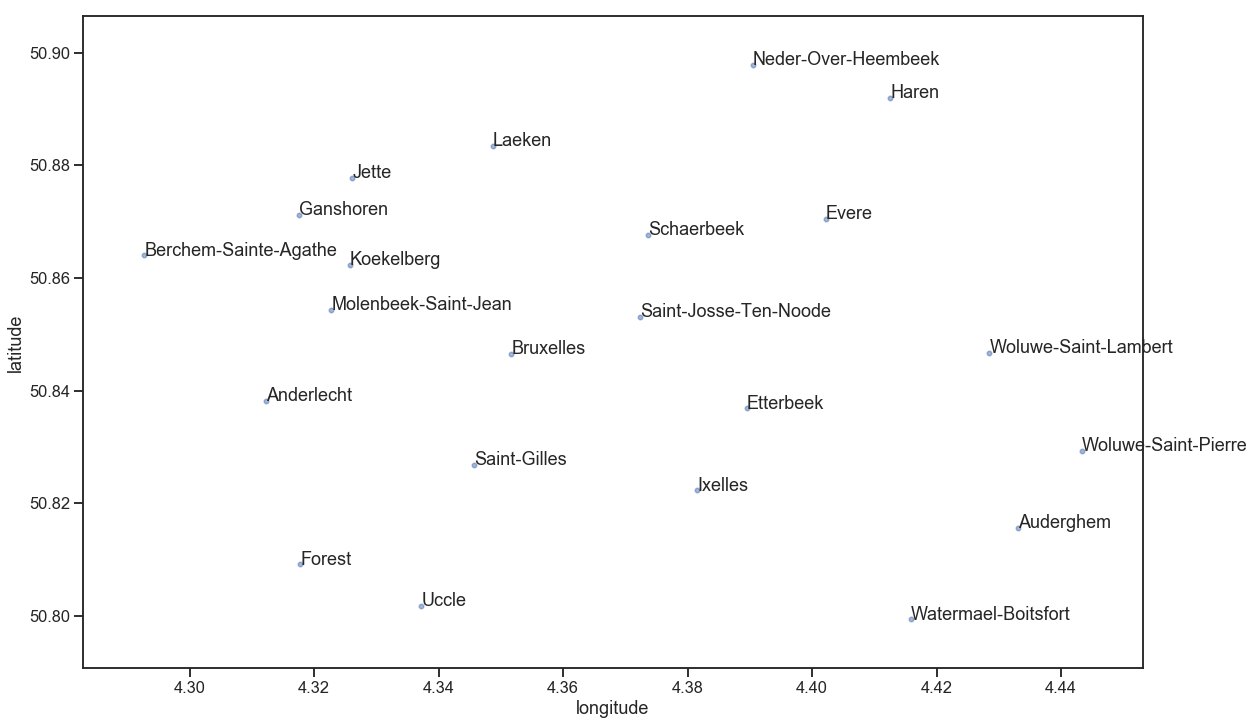

In [31]:
import pandas as pd 
from matplotlib import pyplot as plt 

ax = df_pc.plot.scatter(x='longitude', y='latitude', figsize=(19,12), alpha=0.5)
for i, txt in enumerate(df_pc.locality):
    ax.annotate(txt, (df_pc.longitude.iat[i],df_pc.latitude.iat[i]))
plt.show()

C:\Users\Mathi\Anaconda2\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


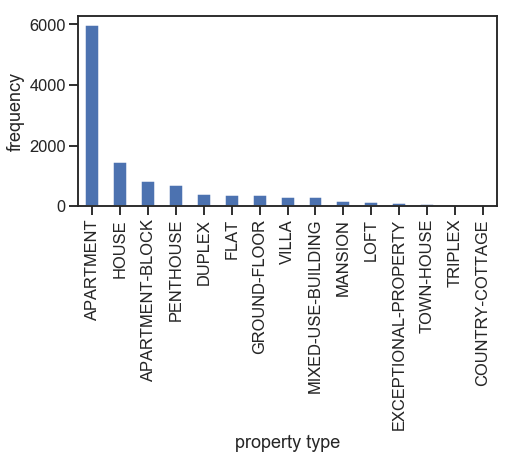

In [32]:
import matplotlib.pyplot as plt 
import pandas

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

df['property_subtype'].value_counts().plot(ax=ax, kind='bar', xlabel='property type', ylabel='frequency')

plt.show()

In [33]:
pd.crosstab(df.property_subtype,df.postcode)
df[["property_subtype", "postcode"]].value_counts()

property_subtype  postcode
APARTMENT         1180        971
                  1000        953
                  1050        806
                  1070        388
                  1200        347
                             ... 
GROUND-FLOOR      1081          1
MANSION           1020          1
TOWN-HOUSE        1030          1
                  1020          1
DUPLEX            1081          1
Length: 229, dtype: int64

In [84]:
df['observations'] = df.groupby('postcode')['price'].count()
pc_w_data = df.groupby('postcode')['price'].count()>500
df_pc_w_data = pc_w_data.to_frame()
df_pc_w_data['postcode'] = df_pc_w_data.index
df_pc_w_data.reset_index(drop=True, inplace=True)
df_pc_w_data.loc[df_pc_w_data.postcode == "1090", "price"] = True
df_filter = df_pc_w_data[df_pc_w_data['price']==True]
#df_filter = df_filter.rename(columns={"price": "filter"})
#df_filter
#pc_w_data['observations'] = pc_w_data.groupby('postcode')['price'].count()

,price,postcode
0,True,1000
2,True,1030
4,True,1050
6,True,1070
7,True,1080
11,True,1090
15,True,1150
18,True,1180
20,True,1200


In [35]:
new_df = pd.merge(df,df_filter,on='postcode')
new_df
   

,property_subtype,price,rooms_number,area,postcode,filter
0,HOUSE,545000,4.0,235.0,1200,True
1,APARTMENT-BLOCK,1750000,7.0,550.0,1200,True
2,HOUSE,550000,4.0,180.0,1200,True
3,APARTMENT-BLOCK,550000,3.0,160.0,1200,True
4,APARTMENT-BLOCK,775000,5.0,220.0,1200,True
...,...,...,...,...,...,...
8727,NaN,200000,2.0,100.0,1080,True
8728,NaN,205000,2.0,80.0,1080,True
8729,NaN,189000,2.0,82.0,1080,True
8730,NaN,160000,1.0,80.0,1080,True


In [36]:
full_df = pd.merge(new_df, df_pc, on='postcode')
full_df

,property_subtype,price,rooms_number,area,postcode,filter,locality,longitude,latitude
0,HOUSE,545000,4.0,235.0,1200,True,Woluwe-Saint-Lambert,4.428484,50.846693
1,APARTMENT-BLOCK,1750000,7.0,550.0,1200,True,Woluwe-Saint-Lambert,4.428484,50.846693
2,HOUSE,550000,4.0,180.0,1200,True,Woluwe-Saint-Lambert,4.428484,50.846693
3,APARTMENT-BLOCK,550000,3.0,160.0,1200,True,Woluwe-Saint-Lambert,4.428484,50.846693
4,APARTMENT-BLOCK,775000,5.0,220.0,1200,True,Woluwe-Saint-Lambert,4.428484,50.846693
...,...,...,...,...,...,...,...,...,...
8727,NaN,200000,2.0,100.0,1080,True,Molenbeek-Saint-Jean,4.322778,50.854355
8728,NaN,205000,2.0,80.0,1080,True,Molenbeek-Saint-Jean,4.322778,50.854355
8729,NaN,189000,2.0,82.0,1080,True,Molenbeek-Saint-Jean,4.322778,50.854355
8730,NaN,160000,1.0,80.0,1080,True,Molenbeek-Saint-Jean,4.322778,50.854355


C:\Users\Mathi\Anaconda2\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


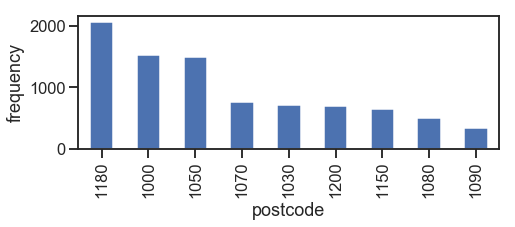

In [37]:
import matplotlib.pyplot as plt 
import pandas

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

full_df['postcode'].value_counts().plot(ax=ax, kind='bar', xlabel='postcode', ylabel='frequency')

plt.show()

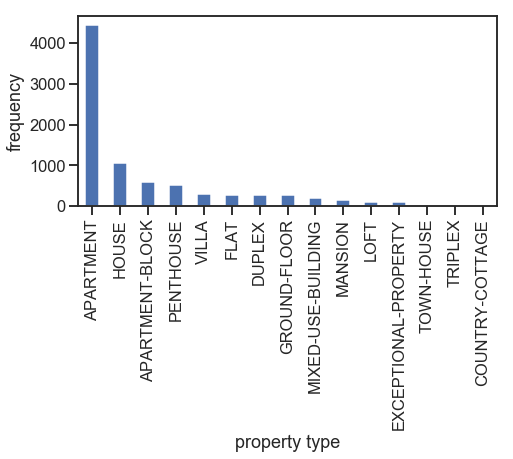

In [38]:
import matplotlib.pyplot as plt 
import pandas

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

full_df['property_subtype'].value_counts().plot(ax=ax, kind='bar', xlabel='property type', ylabel='frequency')

plt.show()

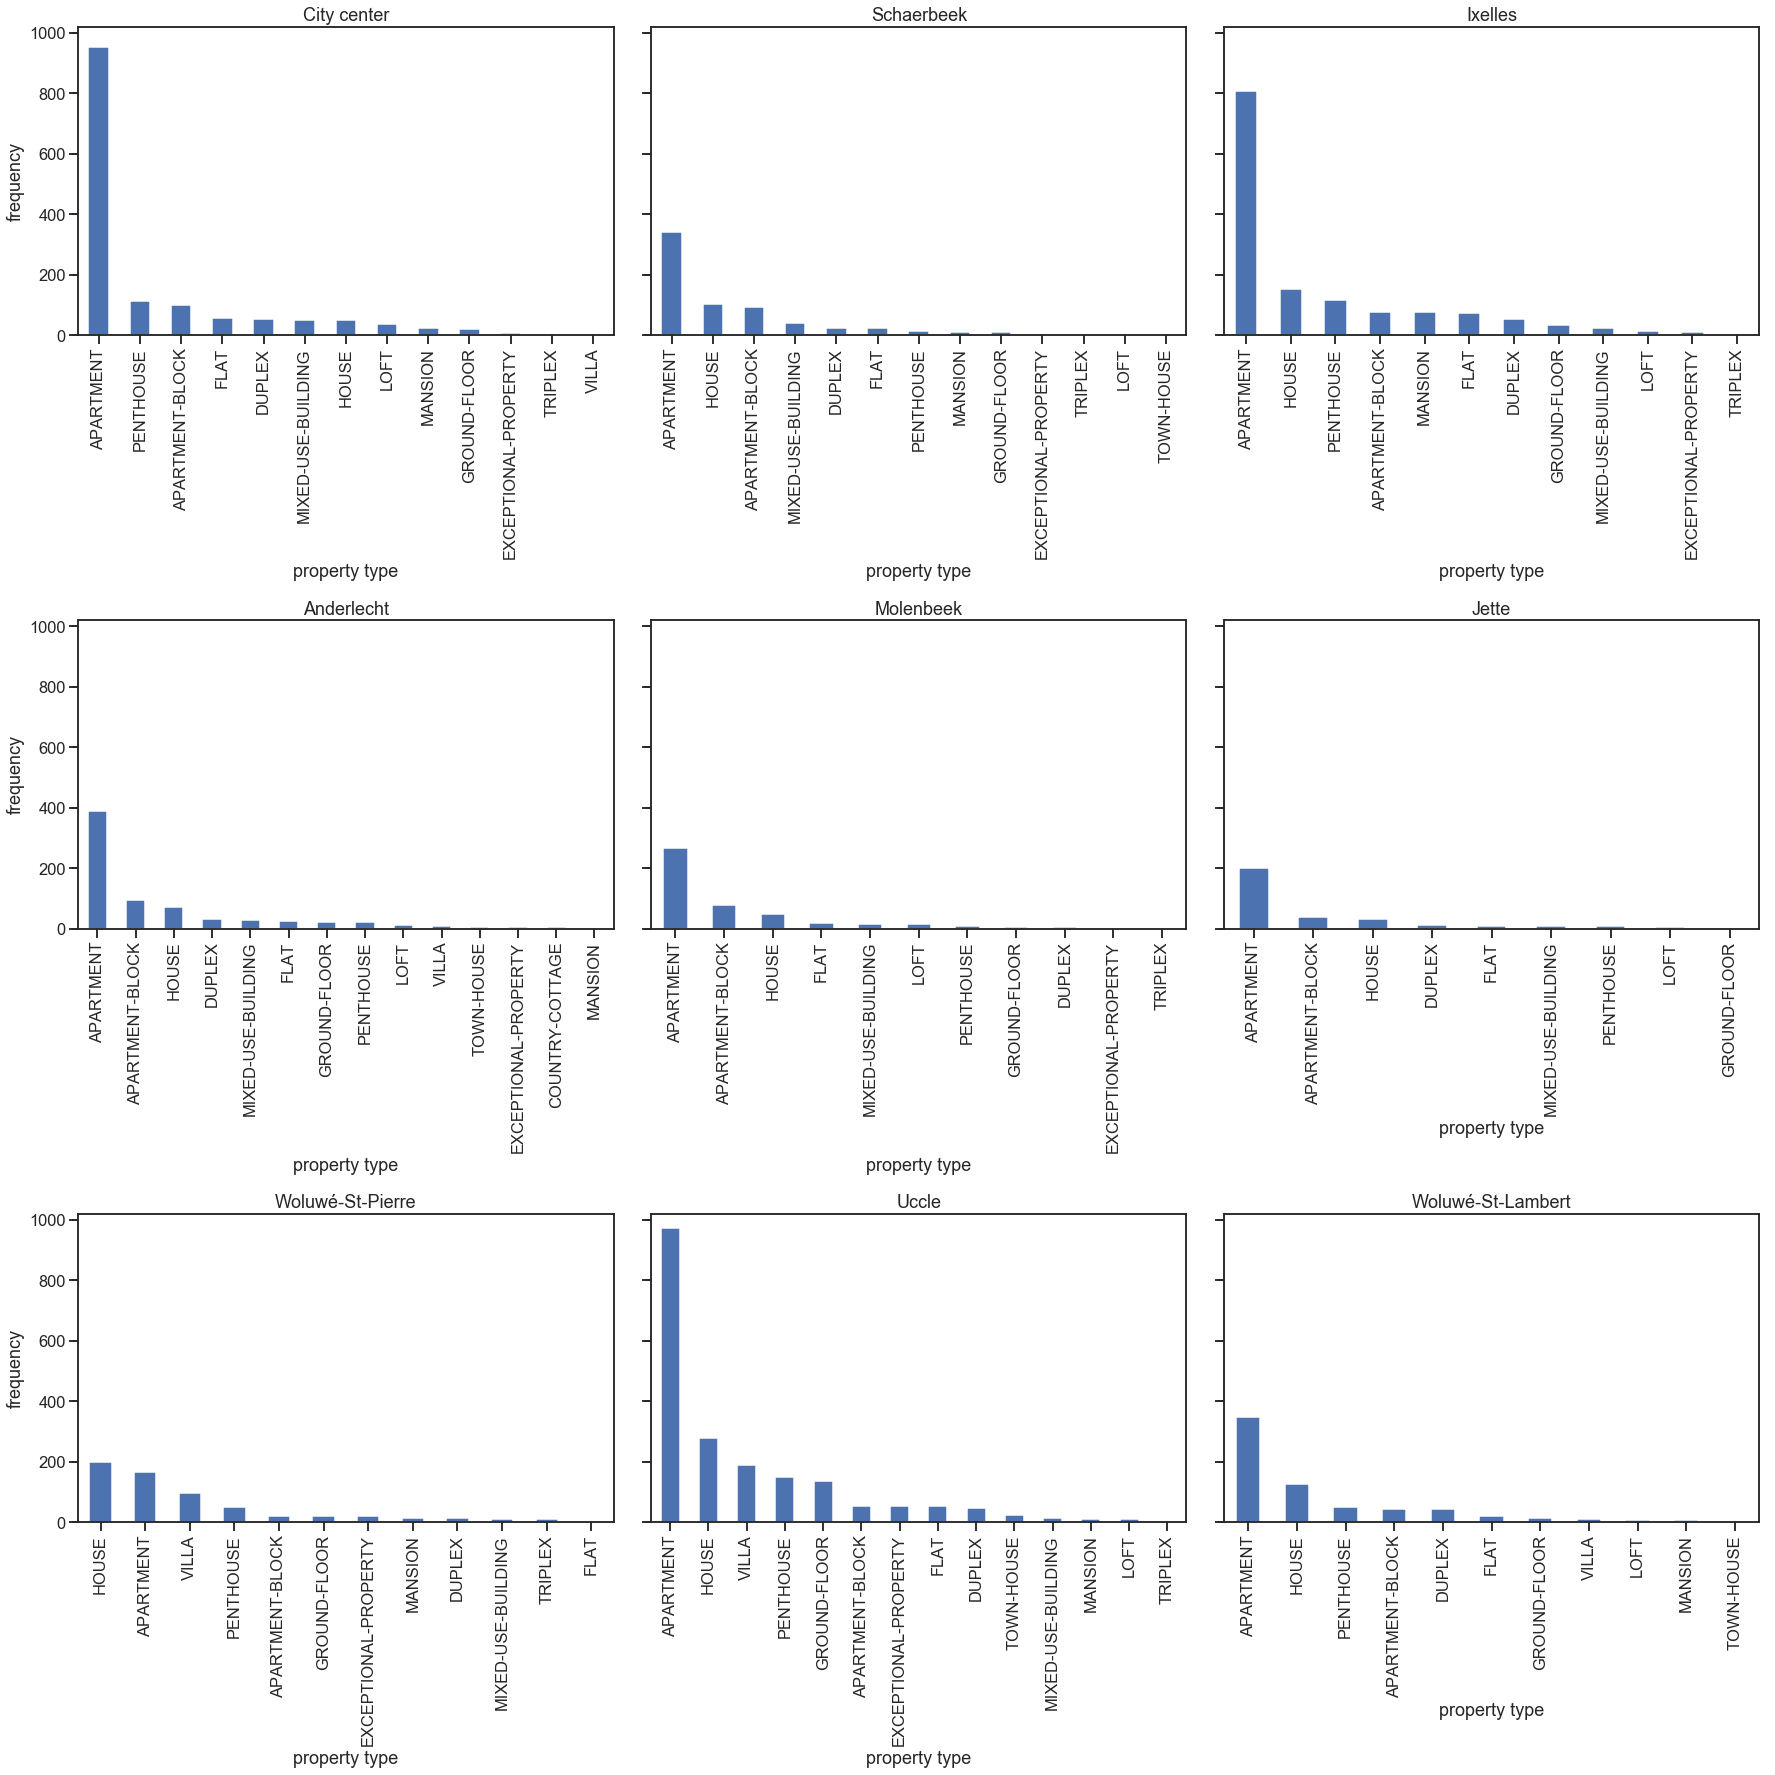

In [49]:
import matplotlib.pyplot as plt 
import pandas

fig, axes = plt.subplots( nrows=3, ncols=3, sharey=True, figsize=(25,25) )

ax00 = full_df[full_df['postcode']=="1000"]['property_subtype'].value_counts().plot(ax=axes[0,0], kind='bar', xlabel='property type', ylabel='frequency')
ax01 = full_df[full_df['postcode']=="1030"]['property_subtype'].value_counts().plot(ax=axes[0,1], kind='bar', xlabel='property type', ylabel='frequency')
ax02 = full_df[full_df['postcode']=="1050"]['property_subtype'].value_counts().plot(ax=axes[0,2], kind='bar', xlabel='property type', ylabel='frequency')
ax10 = full_df[full_df['postcode']=="1070"]['property_subtype'].value_counts().plot(ax=axes[1,0], kind='bar', xlabel='property type', ylabel='frequency')
ax11 = full_df[full_df['postcode']=="1080"]['property_subtype'].value_counts().plot(ax=axes[1,1], kind='bar', xlabel='property type', ylabel='frequency')
ax12 = full_df[full_df['postcode']=="1090"]['property_subtype'].value_counts().plot(ax=axes[1,2], kind='bar', xlabel='property type', ylabel='frequency')
ax20 = full_df[full_df['postcode']=="1150"]['property_subtype'].value_counts().plot(ax=axes[2,0], kind='bar', xlabel='property type', ylabel='frequency')
ax21 = full_df[full_df['postcode']=="1180"]['property_subtype'].value_counts().plot(ax=axes[2,1], kind='bar', xlabel='property type', ylabel='frequency')
ax22 = full_df[full_df['postcode']=="1200"]['property_subtype'].value_counts().plot(ax=axes[2,2], kind='bar', xlabel='property type', ylabel='frequency')

ax00.title.set_text("City center")
ax01.title.set_text("Schaerbeek")
ax02.title.set_text("Ixelles")
ax10.title.set_text("Anderlecht")
ax11.title.set_text("Molenbeek")
ax12.title.set_text("Jette") 
ax20.title.set_text("Woluwé-St-Pierre")
ax21.title.set_text("Uccle")
ax22.title.set_text("Woluwé-St-Lambert")


plt.show()

1388986.4157123226

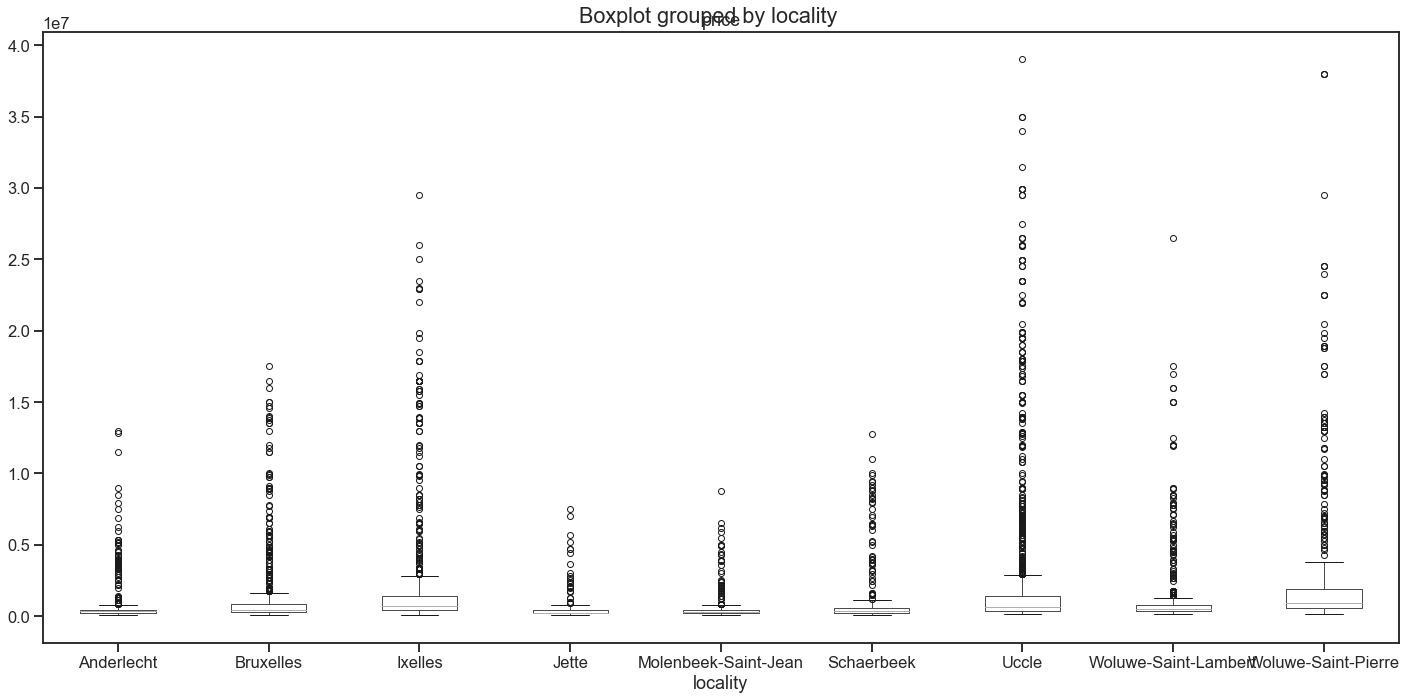

In [57]:
full_df.boxplot(by ='locality', column =['price'], figsize=(20, 10), grid = False)

In [58]:
low_df = full_df[full_df['price']<1000000]

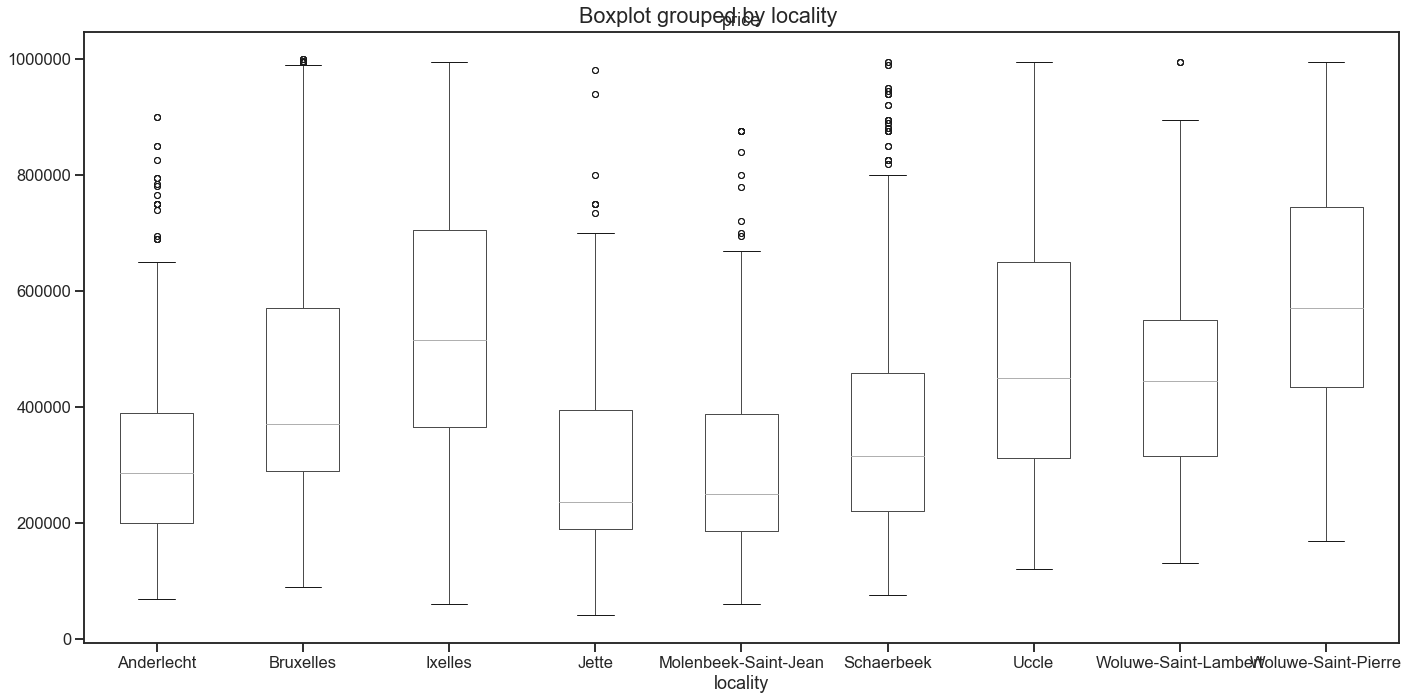

In [60]:
low_df.boxplot(by ='locality', column =['price'], figsize=(20, 10), grid = False)

C:\Users\Mathi\Anaconda2\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


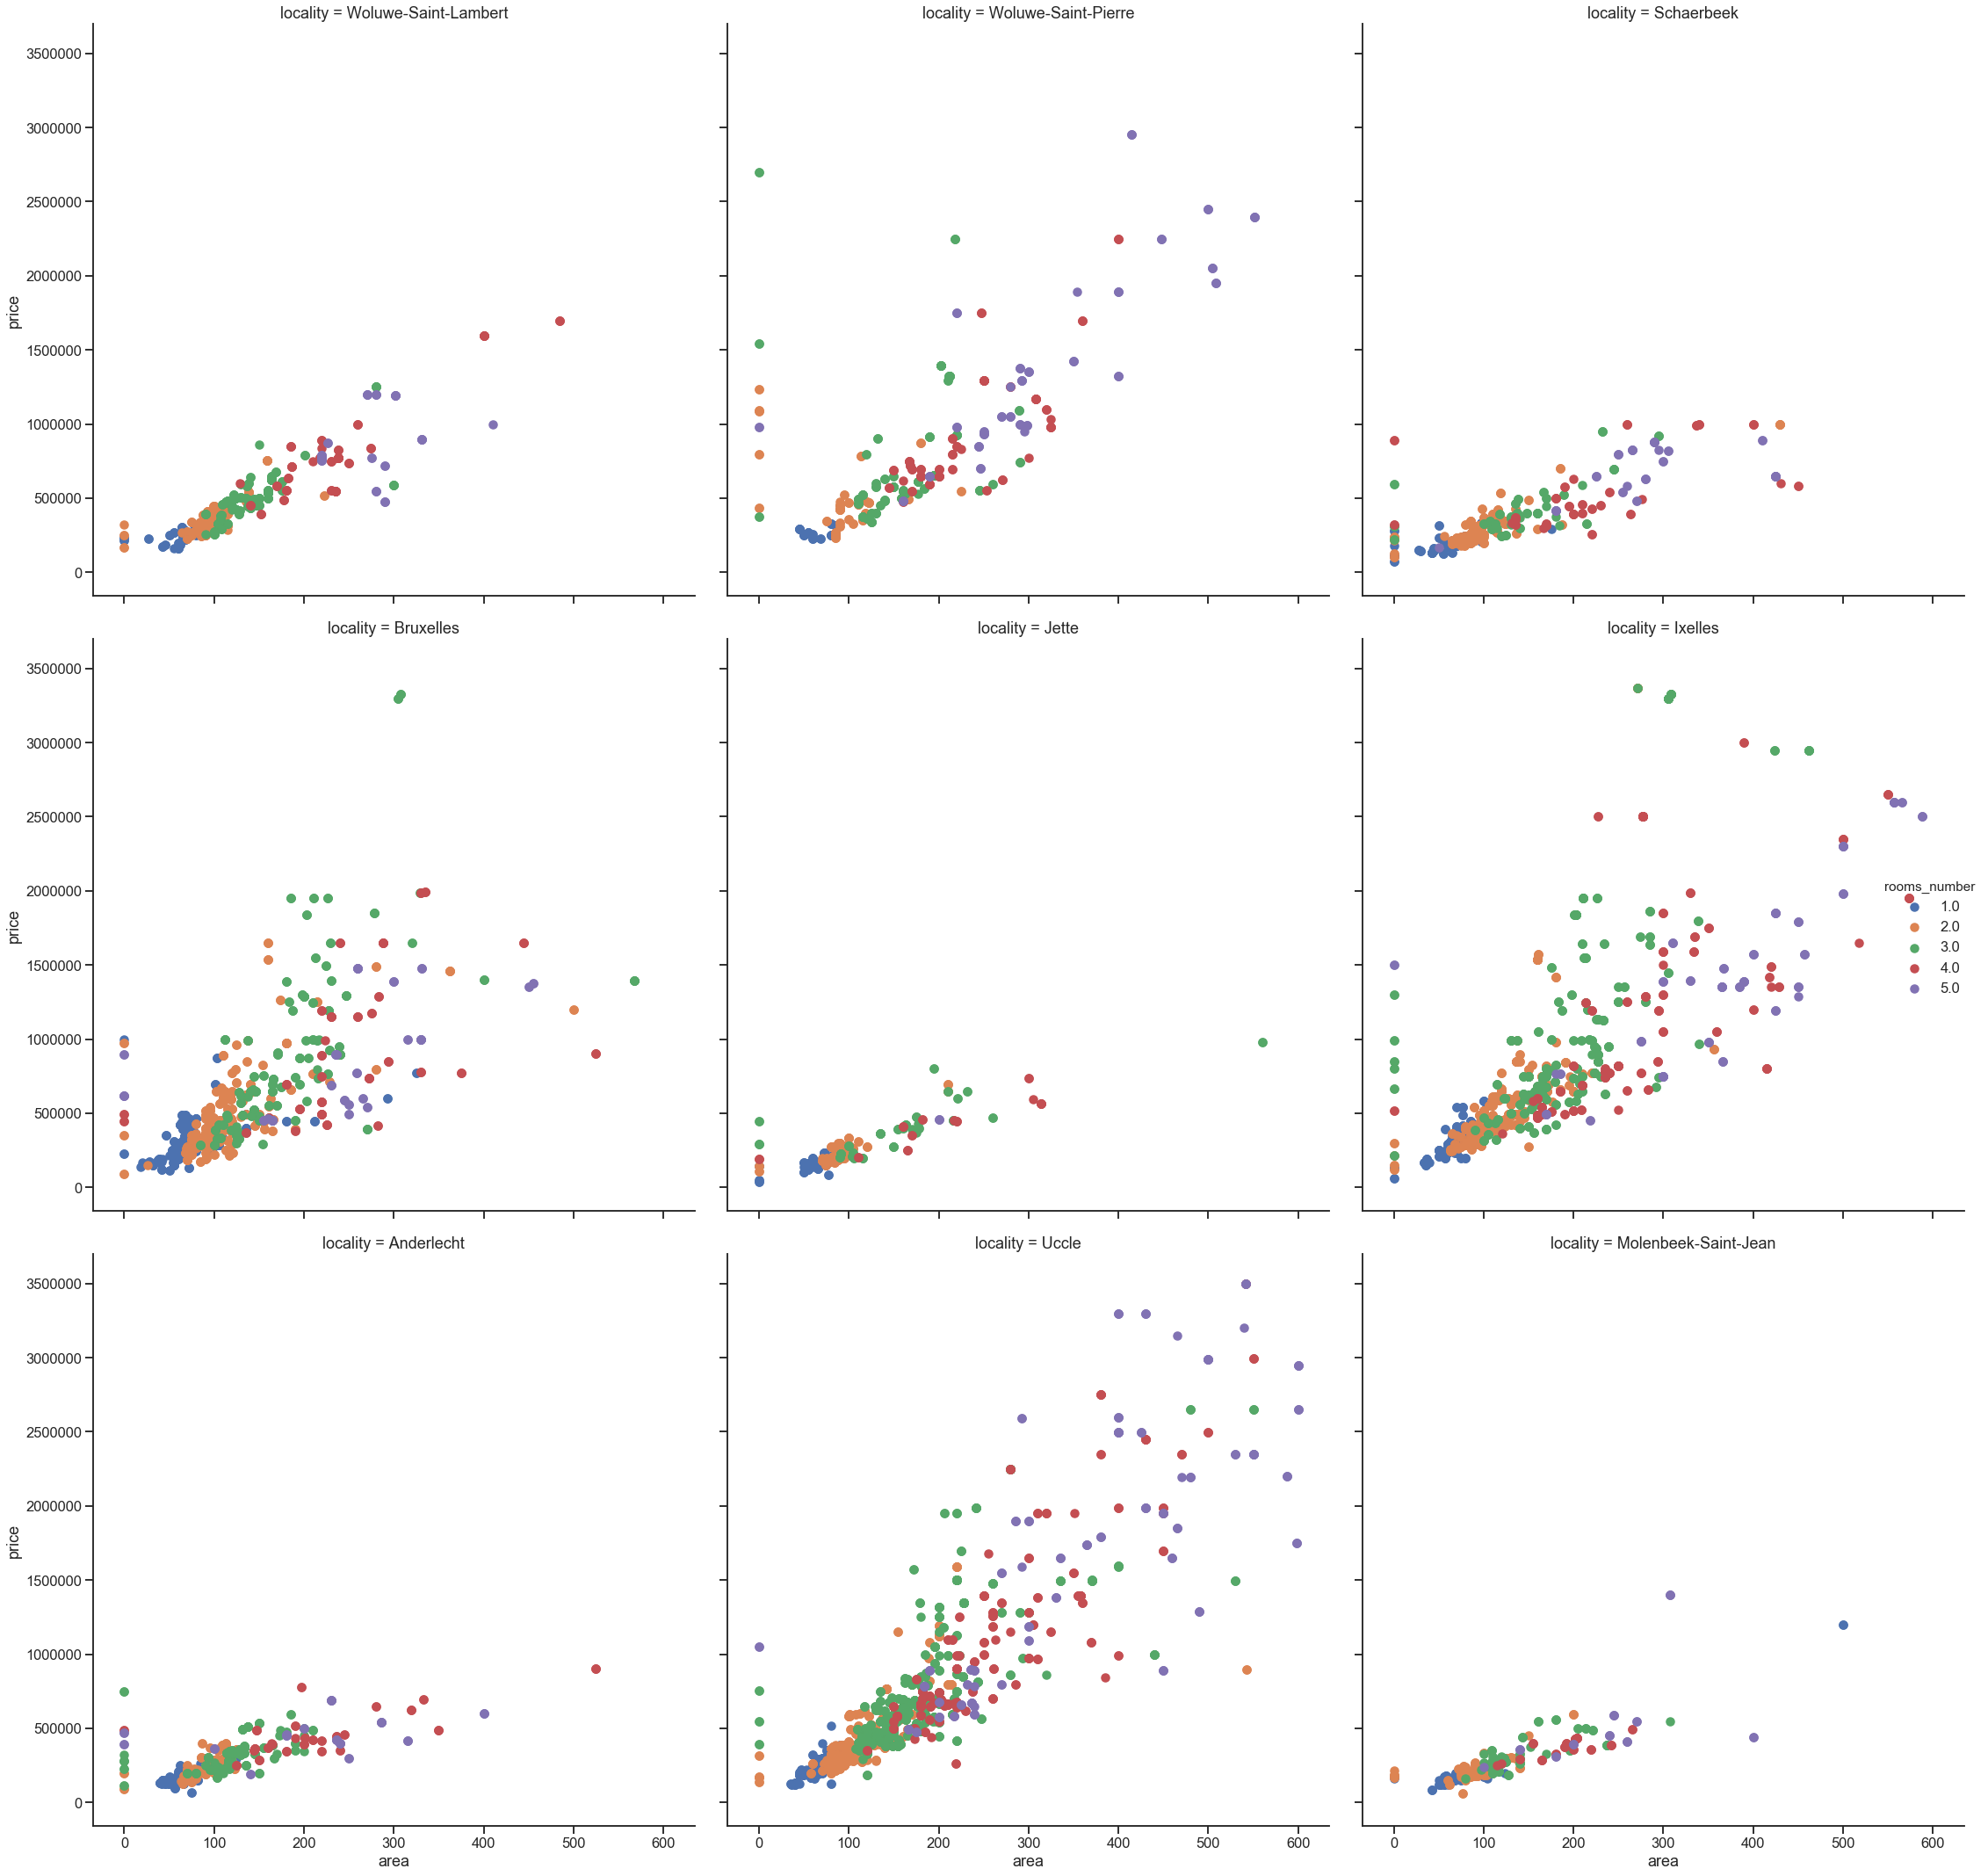

In [76]:
import seaborn as sns
avg_size_df = full_df[(full_df['rooms_number']>0)&(full_df['rooms_number']<6)]
fg = sns.FacetGrid(data=avg_size_df, col = 'locality', hue='rooms_number', col_wrap=3, height = 10, aspect=1)
fg.map(plt.scatter, 'area', 'price').add_legend()